# Inception Module

## Objectives
- create an inception module function
- strip down the convolutional layer function to be suitable for use by the convolutional layer
- replace the convolutional layers with inception modules in the computational graph
- investigate the performance of Gradient Descent and Adam Optimizer with the Inception Module

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [2]:
tf.__version__

'1.0.0'

<img align="left" src="files/old.png"> **Load data**

In [3]:
training_file = './data/train2.p'
testing_file = './data/test2.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

<img align="left" src="files/old.png"> **Standardize naming** 

In [4]:
xtr = train['features']
ytr = train['labels']

xva, xte, yva, yte = train_test_split(test['features'], test['labels'], test_size=0.5)

<img align="left" src="files/old.png"> **One hot encoding**

In [5]:
encoder = LabelBinarizer()
encoder.fit(ytr)
ytr = encoder.transform(ytr).astype(float)
yte = encoder.transform(yte).astype(float)
yva = encoder.transform(yva).astype(float)

<img align="left" src="files/old.png"> **Normalize the input**

In [6]:
def normalize(x_in,y_in):
    
    x_out = []
    y_out = []
    for i, (image, label) in enumerate(zip(x_in, y_in)):
        zeros = np.zeros((32,32,3))
        norm_image = cv2.normalize(image, zeros, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        x_out.append(norm_image)
        y_out.append(label)

    return x_out, y_out

In [7]:
xtr, ytr = normalize(xtr,ytr)
xte, yte = normalize(xte,yte)
xva, yva = normalize(xva,yva)

<img align="left" src="files/modified.png"> **Convolutional layer:** take out themax pool and ReLU operations

In [8]:
def convolutional_layer(input, filter_size, in_channels, out_channels):

    filter_shape = [filter_size, filter_size, in_channels, out_channels]
    biases_shape = [out_channels]
    
    filter = tf.Variable(tf.truncated_normal(shape=filter_shape, mean=0, stddev=0.1))
    biases = tf.Variable(tf.constant(0.1, shape=biases_shape))
    
    return tf.nn.conv2d(input, filter, strides=[1, 1, 1, 1], padding='SAME') + biases

<img align="left" src="files/new.png"> **Inception module**

In [9]:
def inception_module(layer_in, channels_in, intermediate ,channels_out):

    convolution_1x1  = convolutional_layer(layer_in,         1, channels_in,  channels_out)
    
    conv_1x1_for_3x3 = convolutional_layer(layer_in,         1, channels_in,  intermediate)
    convolution_3x3  = convolutional_layer(conv_1x1_for_3x3, 3, intermediate, channels_out)
    
    conv_1x1_for_5x5 = convolutional_layer(layer_in,         1, channels_in,  intermediate)
    convolution_5x5  = convolutional_layer(conv_1x1_for_5x5, 5, intermediate, channels_out)

    maxpool          = tf.nn.max_pool(layer_in,[1,3,3,1],[1,1,1,1],padding='SAME')
    maxpool_conv_1x1 = convolutional_layer(maxpool, 1, channels_in, channels_out)
    
    result = tf.concat([convolution_1x1, convolution_3x3, convolution_5x5, maxpool_conv_1x1], 3)
    
    result = tf.nn.relu(result)
    
    return result

<img align="left" src="files/old.png"> **Flatten the layer**

In [10]:
def flatten_layer(input):
    
    layer_shape = input.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    
    return layer_flat, num_features

<img align="left" src="files/old.png"> **Fully connected layer**

In [11]:
def fully_connected_layer(input, num_features, num_outputs):
    
    weights = tf.Variable(tf.truncated_normal([num_features, num_outputs], stddev=0.05))
    biases = tf.Variable(tf.constant(0.05, shape=[num_outputs]))

    output = tf.matmul(input, weights) + biases
    
    return output

<img align="left" src="files/old.png"> **Optimize**

In [12]:
def optimize(optimizer, l_rate, keep_probability, iterations, x_train, y_train, batch_size):
    
    for i in range(0,iterations):  
        x1, x2, y1, y2 = train_test_split(x_train, y_train, train_size=batch_size, random_state=i)        
        sess.run(optimizer, feed_dict = {x: x1, y: y1, learning_rate: l_rate, keep_prob: keep_probability})

<img align="left" src="files/old.png"> **Test accuracy**

In [13]:
def test_accuracy(logits,x_data,y_data):
    
    y_pred = tf.nn.softmax(logits)
    
    y_pred_cls = tf.argmax(y_pred, dimension=1)
    y_true_cls = tf.argmax(y, dimension=1)

    prediction = tf.equal(y_pred_cls, y_true_cls)    
    
    num_examples = len(x_data)
    batch_size = 1024
    all_predictions = []
    
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = x_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
        all_predictions.extend(sess.run(prediction, feed_dict = {x: batch_x, y: batch_y, keep_prob: 1})) 
    
    return np.mean(all_predictions)

<img align="left" src="files/old.png"> **Same training**

In [14]:
def run_training(logits, optimizer, l_rate, keep, tick_size, n_ticks, xtr, ytr, xte, yte, train_batch, verbose):
    
    sess.run(tf.global_variables_initializer())
    
    result = [[],[],[],0]

    for i in range(1,n_ticks+1):    
        optimize(optimizer, l_rate, keep, tick_size, xtr, ytr, train_batch)        
        tr_a = test_accuracy(logits,xtr,ytr)
        te_a = test_accuracy(logits,xte,yte)
        result[0].append(tr_a)
        result[1].append(te_a)
        result[2].append(i*tick_size)
        if verbose:
            print i, tr_a, te_a
    result[3] = test_accuracy(logits,xva,yva)
    return result

## Build the computational graph using the defined functions
<img align="left" src="files/modified.png"> **Replace convolution layers with the inception modules**

In [15]:
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, 43])

learning_rate = tf.placeholder(tf.float32)
keep_prob = tf.placeholder(tf.float32)

inception_1 = inception_module(x,            3,  8, 16)
inception_2 = inception_module(inception_1, 64, 16, 32)

layer_flat, num_features = flatten_layer(inception_2)

layer_1 = fully_connected_layer(layer_flat, num_features, 512)
layer_1 = tf.nn.relu(layer_1)

layer_1   = tf.nn.dropout(layer_1, keep_prob)

logits = fully_connected_layer(layer_1, 512, 43)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y)
cost = tf.reduce_mean(cross_entropy)

grad = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
adam = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [16]:
sess = tf.Session()

## Gradient Descent vs Adam Optimizer for Inception Module

In [17]:
r1, e1, t1, v1 = run_training(logits, grad, 0.0001, 0.5, 200, 20, xtr, ytr, xte, yte, 64, 0)

In [18]:
r2, e2, t2, v2 = run_training(logits, adam, 0.0001, 0.5, 200, 20, xtr, ytr, xte, yte, 64, 0)

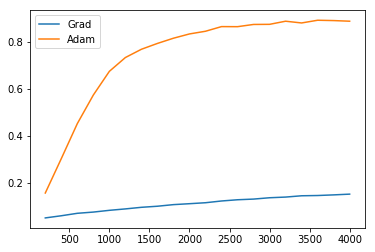

In [19]:
plt.plot(t1,e1, label='Grad')
plt.plot(t2,e2, label='Adam')
plt.legend()
plt.show()

## Learning Rate

In [20]:
r3, e3, t3, v3 = run_training(logits, adam, 0.001, 0.5, 5000, 20, xtr, ytr, xte, yte, 64, 0)

In [21]:
r4, e4, t4, v4 = run_training(logits, adam, 0.0001, 0.5, 5000, 20, xtr, ytr, xte, yte, 64, 0)

In [22]:
r5, e5, t5, v5 = run_training(logits, adam, 0.00001, 0.5, 5000, 20, xtr, ytr, xte, yte, 64, 0)

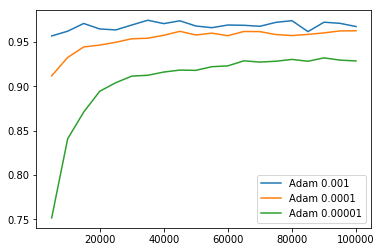

In [23]:
plt.plot(t3,e3, label='Adam 0.001')
plt.plot(t4,e4, label='Adam 0.0001')
plt.plot(t5,e5, label='Adam 0.00001')
plt.legend()
plt.show()

## Batch Size

In [24]:
r6, e6, t6, v6 = run_training(logits, adam, 0.0001, 0.5, 5000, 20, xtr, ytr, xte, yte, 16, 0)

In [25]:
r7, e7, t7, v7 = run_training(logits, adam, 0.0001, 0.5, 5000, 20, xtr, ytr, xte, yte, 32, 0)

In [26]:
r8, e8, t8, v8 = run_training(logits, adam, 0.0001, 0.5, 5000, 20, xtr, ytr, xte, yte, 128, 0)

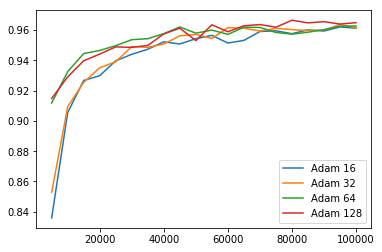

In [27]:
plt.plot(t6,e6, label='Adam 16')
plt.plot(t7,e7, label='Adam 32')
plt.plot(t4,e4, label='Adam 64')
plt.plot(t8,e8, label='Adam 128')
plt.legend()
plt.show()

In [28]:
v1, v2, v3, v4, v5, v6, v7, v8

(0.14885193982581155,
 0.88582739509105302,
 0.96642913697545529,
 0.961520190023753,
 0.92430720506730013,
 0.96373713380839277,
 0.96247030878859863,
 0.96516231195566116)